In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import BDay
from tqdm.notebook import tqdm # 使用 notebook 友好的进度条
import os
import warnings
warnings.filterwarnings('ignore')
# 设置全局中文字体
# 'PingFang HK' 在 macOS 上表现稳定且美观
plt.rcParams['font.sans-serif'] = ['PingFang HK', 'STHeiti', 'Arial Unicode MS'] 

# 解决保存图像时负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False 

In [37]:
fs_df = pd.read_csv('data/ind_financial_indicators_2015q1_2025q2.csv')

df = fs_df[['ts_code','ann_date','end_date','q_sales_yoy','q_profit_yoy','l3_name']].copy()

In [38]:
ind_list = [
    "制冷空调设备",    # 对应: 液冷
    "其他专用设备",    # 对应: 液冷
    "光学元件",        # 对应: 光芯片
    "通信网络设备及器件",  # 对应: 光芯片
    "半导体材料",      # 对应: 光芯片
    "锂",              # 对应: 锂矿
    "锂电池",          # 对应: 动力电池, 储能
    "电池化学品",      # 对应: 电池正极、负极、电解液
    "膜材料",          # 对应: 隔膜
    "风电整机",        # 对应: 风电风机
    "风电零部件",      # 对应: 风电轴承, 风电电缆
    "线缆部件及其他",  # 对应: 风电电缆
    "硅料硅片",        # 对应: 光伏硅料、硅片
    "光伏电池组件",    # 对应: 光伏电池
    "玻璃制造",        # 对应: 光伏玻璃
    "光伏辅材",        # 对应: 光伏玻璃
    "逆变器",          # 对应: 逆变器, 储能
    "蓄电池及其他电池" # 对应: 储能
]

In [39]:
# 在df中筛选l3_name在ind_list中的数据
df_ind = df[df['l3_name'].isin(ind_list)].copy()

In [40]:
df_ind.isnull().sum()

ts_code           0
ann_date          0
end_date          0
q_sales_yoy     781
q_profit_yoy    782
l3_name           0
dtype: int64

In [41]:
df_ind.describe()

,q_sales_yoy,q_profit_yoy
count,11002.000000,11001.000000
mean,25.994965,41.700027
std,132.270314,3374.138558
min,-570.320200,-81699.420500
25%,-7.610725,-46.976700
50%,11.431550,8.048500
75%,36.351575,76.874200
max,9502.738700,301125.465500


In [42]:
# 填充缺失值：按“报告期”和“行业”分组，然后用该组的“中位数”来填充组内的缺失值
for col in ['q_sales_yoy', 'q_profit_yoy']:
    df_ind[col] = df_ind.groupby(['end_date', 'l3_name'])[col].transform(
        lambda x: x.fillna(x.median())
    )

# 使用“市场中位数”进行截面填充,来填充第一步未填充的缺失值  
for col in ['q_sales_yoy', 'q_profit_yoy']:
    df_ind[col] = df_ind.groupby('end_date')[col].transform(
        lambda x: x.fillna(x.median())
    )
    
# 还有缺失值的行删除
df_ind.dropna(subset=['q_sales_yoy', 'q_profit_yoy'], inplace=True)

In [43]:
# 缩尾处理(将所有高于 99% 分位数的值“拉回”到 99% 分位数的值，将所有低于 1% 分位数的值“拉升”到 1% 分位数的值)
cols_to_process = ['q_sales_yoy', 'q_profit_yoy']

# 设置缩尾的百分位
p_low = 0.01  # 1%
p_high = 0.99 # 99%

for col in cols_to_process:
    # 计算1%和99%的分位数
    low_val = df_ind[col].quantile(p_low)
    high_val = df_ind[col].quantile(p_high)
    
    print(f"处理 {col}: 1% 分位数 = {low_val:.2f}, 99% 分位数 = {high_val:.2f}")
    
    # 使用 .clip() 函数进行缩尾
    df_ind[col] = df_ind[col].clip(lower=low_val, upper=high_val)

print("\n缩尾处理完成。")

处理 q_sales_yoy: 1% 分位数 = -69.37, 99% 分位数 = 281.74
处理 q_profit_yoy: 1% 分位数 = -1708.62, 99% 分位数 = 1998.76

缩尾处理完成。


In [44]:
df_ind.describe()

,q_sales_yoy,q_profit_yoy
count,11777.000000,11777.000000
mean,21.594743,35.318326
std,53.325150,365.873732
min,-69.373052,-1708.621616
25%,-6.234300,-42.808700
50%,11.845100,8.913900
75%,35.342200,72.515500
max,281.737844,1998.757308


In [45]:
df_ind['l3_name'].unique()

array(['电池化学品', '玻璃制造', '锂电池', '通信网络设备及器件', '光伏辅材', '锂', '制冷空调设备',
       '线缆部件及其他', '其他专用设备', '膜材料', '光学元件', '光伏电池组件', '半导体材料', '硅料硅片',
       '风电整机', '风电零部件', '蓄电池及其他电池', '逆变器'], dtype=object)

In [46]:
df_ind

,ts_code,ann_date,end_date,q_sales_yoy,q_profit_yoy,l3_name
236,000009.SZ,2015-04-29,2015-03-31,15.1639,-13.6133,电池化学品
237,000009.SZ,2015-08-28,2015-06-30,6.0100,-36.9593,电池化学品
238,000009.SZ,2015-10-31,2015-09-30,34.0505,703.5780,电池化学品
239,000009.SZ,2016-04-29,2016-03-31,52.7519,1.8531,电池化学品
240,000009.SZ,2016-08-30,2016-06-30,29.6020,-24.0442,电池化学品
...,...,...,...,...,...,...
163987,920682.BJ,2024-08-24,2024-06-30,22.4453,0.3290,线缆部件及其他
163988,920682.BJ,2024-10-30,2024-09-30,58.3800,51.3643,线缆部件及其他
163989,920682.BJ,2025-03-29,2024-12-31,4.4360,0.1728,线缆部件及其他
163990,920682.BJ,2025-04-29,2025-03-31,5.6347,-24.1134,线缆部件及其他


In [47]:
price_df = pd.read_csv('data/stk_ind_data_20150101_20251017.csv')
price_df = price_df[['ts_code','trade_date','close','total_mv','l3_name']]
price_df = price_df[price_df['l3_name'].isin(ind_list)]
price_df.reset_index(inplace=True,drop=True)
price_df['trade_date'] = pd.to_datetime(price_df['trade_date'], format='%Y%m%d')

In [48]:
price_df

,ts_code,trade_date,close,total_mv,l3_name
0,300151.SZ,2025-10-17,12.95,6.895989e+05,其他专用设备
1,601615.SH,2025-10-17,15.30,3.475390e+06,风电整机
2,002882.SZ,2025-10-17,28.88,1.250215e+06,线缆部件及其他
3,002506.SZ,2025-10-17,2.47,1.445028e+06,光伏电池组件
4,300035.SZ,2025-10-17,22.49,1.541525e+06,电池化学品
...,...,...,...,...,...
748672,002613.SZ,2015-01-05,7.99,3.839994e+05,玻璃制造
748673,600072.SH,2015-01-05,11.44,5.473234e+05,风电零部件
748674,300382.SZ,2015-01-05,58.58,3.118623e+05,其他专用设备
748675,002595.SZ,2015-01-05,24.59,9.836000e+05,其他专用设备


In [49]:
def robust_merge_asof(left_df, right_df, left_on, right_on, by):
    """执行稳健的合并操作，确保在合并时考虑到时间序列的顺序。"""
    print(f"--- Performing robust merge_asof on '{by}' ---")

    # 优化: 确保合并键也是 category
    #if pd.api.types.is_categorical_dtype(left_df[by]) and not pd.api.types.is_categorical_dtype(right_df[by]):
        #right_df[by] = right_df[by].astype('category')
    
    left_df = left_df.reset_index(drop=True).sort_values(by=[by, left_on])
    right_df = right_df.reset_index(drop=True).sort_values(by=[by, right_on])
    all_keys = left_df[by].unique()
    merged_chunks = []
    for key in all_keys:
        left_chunk = left_df[left_df[by] == key]
        right_chunk = right_df[right_df[by] == key]
        merged_chunk = pd.merge_asof(
            left=left_chunk, right=right_chunk, left_on=left_on,
            right_on=right_on, by=by, direction='backward'
        )
        merged_chunks.append(merged_chunk)
    print("Robust merge successful.")
    return pd.concat(merged_chunks, ignore_index=True)


In [50]:
df_ind['ann_date'] = pd.to_datetime(df_ind['ann_date'])
financial_cols = ['ts_code', 'ann_date', 'end_date', 'q_sales_yoy', 'q_profit_yoy', 'l3_name']
df_ind_subset = df_ind[financial_cols].copy()

# 【修复】使用你的新函数
merged_df = robust_merge_asof(
    price_df,                       
    df_ind_subset,                  
    left_on='trade_date',           
    right_on='ann_date',          
    by='ts_code',
)

--- Performing robust merge_asof on 'ts_code' ---
Robust merge successful.


In [51]:
# 确保只删除 _y 后缀的列 (如果存在)
if 'l3_name_y' in merged_df.columns:
    merged_df = merged_df.drop(columns=['l3_name_y'])

In [52]:
df = merged_df.dropna().copy()

In [53]:
df.rename(columns={'l3_name_x': 'l3_name'}, inplace=True)

In [54]:
df

,ts_code,trade_date,close,total_mv,l3_name,ann_date,end_date,q_sales_yoy,q_profit_yoy
74,000009.SZ,2015-04-29,21.07,3.354570e+06,电池化学品,2015-04-29,2015-03-31,15.1639,-13.6133
75,000009.SZ,2015-04-30,22.38,3.563136e+06,电池化学品,2015-04-29,2015-03-31,15.1639,-13.6133
76,000009.SZ,2015-05-04,22.37,3.561544e+06,电池化学品,2015-04-29,2015-03-31,15.1639,-13.6133
77,000009.SZ,2015-05-05,21.80,3.470794e+06,电池化学品,2015-04-29,2015-03-31,15.1639,-13.6133
78,000009.SZ,2015-05-06,22.10,3.518557e+06,电池化学品,2015-04-29,2015-03-31,15.1639,-13.6133
...,...,...,...,...,...,...,...,...,...
748672,920682.BJ,2025-10-13,9.82,3.186394e+05,线缆部件及其他,2025-08-23,2025-06-30,-0.5330,-1.5003
748673,920682.BJ,2025-10-14,10.00,3.244800e+05,线缆部件及其他,2025-08-23,2025-06-30,-0.5330,-1.5003
748674,920682.BJ,2025-10-15,10.06,3.264269e+05,线缆部件及其他,2025-08-23,2025-06-30,-0.5330,-1.5003
748675,920682.BJ,2025-10-16,9.91,3.215597e+05,线缆部件及其他,2025-08-23,2025-06-30,-0.5330,-1.5003


复现策略：
行业内X%公司连续Z季YoY>Y%→之后M个月上涨R%

Y的四种逻辑：1.只考虑利润 2. 只考虑收入 3.利润和收入同时>Y 4. 利润或收入大于Y

当上述财务指标连续Z个季度>Y时，生成“个股信号”

按行业聚合“个股信号”，如果行业内出发个股信号的比例>X，生成行业信号

将个股信号和行业信号都满足的股票在季度财务报表公告日之后的第一个可交易日等权持有，计算他们未来M个月的平均收益率，胜率(收益率大于0的占比)


In [108]:
print(f"--- 准备对 {len(df)} 行数据进行参数扫描 ---")

# --- 1. 定义参数网格 ---
param_grid = {
    "Y_PROFIT_GROWTH": [20.0, 30.0, 40.0, 50.0, 60, 70, 80, 90, 100],
    "Y_SALES_GROWTH": [5.0, 10.0, 20.0,30,40,50,60,70,80,90,100],
    "Z_QUARTERS": [2,3,4],
    "X_INDUSTRY_PCT": [0.4, 0.5, 0.6, 0.7,0.8,0.9],
    "M_MONTHS": [1, 3, 6],
    # 【修改】增加 'PROFIT_ONLY' 和 'SALES_ONLY'
    "Y_GROWTH_LOGIC": ['AND', 'OR', 'PROFIT_ONLY', 'SALES_ONLY'] 
}

all_results = [] # 存储所有运行结果

# --- 2. 【优化】在循环外计算一次未来收益 ---
# 这一步在所有循环中都是一样的，没必要重复计算
print("--- 正在预先计算所有未来收益... ---")
df_with_returns = df.copy()
df_with_returns = df_with_returns.sort_values(by=['ts_code', 'trade_date'])
for m in tqdm(param_grid["M_MONTHS"], desc="Calculating Future Returns"):
    m_days = m * 21
    return_col = f'future_return_{m}M'
    future_price = df_with_returns.groupby('ts_code')['close'].shift(-m_days)
    df_with_returns[return_col] = (future_price / df_with_returns['close']) - 1
print("--- 未来收益计算完毕 ---")


# --- 3. 开始参数循环 ---
# 使用 product 来自动生成所有组合
from itertools import product

param_combinations = list(product(
    param_grid["Y_PROFIT_GROWTH"],
    param_grid["Y_SALES_GROWTH"],  # <--- Y_profit 和 Y_sales 来自这里
    param_grid["Z_QUARTERS"],
    param_grid["X_INDUSTRY_PCT"],
    param_grid["Y_GROWTH_LOGIC"]
))

# 循环主体
for Y_profit, Y_sales, Z, X, GROWTH_LOGIC in tqdm(param_combinations, desc="Scanning Parameters"):
    
    # --- 步骤 1: 提取唯一的季度财报，并计算“个股信号” ---
    financial_cols = ['ts_code', 'l3_name', 'ann_date', 'end_date', 'q_sales_yoy', 'q_profit_yoy']
    quarterly_df = df[financial_cols].drop_duplicates(subset=['ts_code', 'end_date']).copy()
    quarterly_df = quarterly_df.sort_values(by=['ts_code', 'end_date'])

    # 1.3/1.4: 【修改】标记并组合，以支持 'PROFIT_ONLY' 和 'SALES_ONLY'
    logic_upper = GROWTH_LOGIC.upper()

    if logic_upper == 'PROFIT_ONLY':
        # 只考虑利润
        quarterly_df['is_growth'] = quarterly_df['q_profit_yoy'] > Y_profit
        
    elif logic_upper == 'SALES_ONLY':
        # 只考虑营收
        quarterly_df['is_growth'] = quarterly_df['q_sales_yoy'] > Y_sales
        
    elif logic_upper == 'AND':
        # 必须两者都满足
        is_growth_profit = quarterly_df['q_profit_yoy'] > Y_profit
        is_growth_sales = quarterly_df['q_sales_yoy'] > Y_sales
        quarterly_df['is_growth'] = is_growth_profit & is_growth_sales
        
    elif logic_upper == 'OR':
        # 满足任意一个即可
        is_growth_profit = quarterly_df['q_profit_yoy'] > Y_profit
        is_growth_sales = quarterly_df['q_sales_yoy'] > Y_sales
        quarterly_df['is_growth'] = is_growth_profit | is_growth_sales
        
    else:
        print(f"Warning: Logic {GROWTH_LOGIC} 不支持. Skipping.")
        quarterly_df['is_growth'] = False # 默认不满足

    # 1.5 计算连续Z季 (这部分不变)
    rolling_sum = quarterly_df.groupby('ts_code')['is_growth'].rolling(window=Z).sum()
    quarterly_df['consecutive_growth_count'] = rolling_sum.reset_index(level=0, drop=True)

    # 1.6 生成个股信号 (这部分不变)
    quarterly_df['stock_signal'] = (quarterly_df['consecutive_growth_count'] == Z)
    # --- 步骤 2: 聚合个股信号，计算“行业信号” ---
    industry_pct = quarterly_df.groupby(['ann_date', 'l3_name'])['stock_signal'].mean()
    industry_signal_df = industry_pct.reset_index(name='industry_pct')
    industry_signal_df['strategy_signal'] = (industry_signal_df['industry_pct'] > X)
    good_industries = industry_signal_df[industry_signal_df['strategy_signal'] == True][['ann_date', 'l3_name']].drop_duplicates()

    # --- 步骤 3: (已在循环外完成) ---
    
    # --- 步骤 4: 执行回测 (对每个 M) ---
    good_stocks = quarterly_df[quarterly_df['stock_signal'] == True][['ts_code', 'l3_name', 'ann_date']]
    trade_list = pd.merge(good_stocks, good_industries, on=['ann_date', 'l3_name'], how='inner')
    trade_list = trade_list[['ts_code', 'l3_name', 'ann_date']].drop_duplicates()
    
    if trade_list.empty:
        # 如果这个 (Y, Z, X, Logic) 组合没产生任何信号，就为所有的 M 记录空结果
        for M in param_grid["M_MONTHS"]:
            all_results.append({
                "Y_profit": Y_profit, "Y_sales": Y_sales, "Z": Z, "X": X, "M": M, "Logic": GROWTH_LOGIC, # <--- 已修复
                "avg_return": np.nan, "median_return": np.nan, "win_rate": np.nan,
                "std_dev": np.nan, "sharpe_ratio": np.nan, "num_signals": 0
            })
        continue # 跳过这组参数的 M 循环

    # 准备价格数据 (只需一次)
    trade_list_sorted = trade_list.sort_values(by='ann_date')
    
    for M in param_grid["M_MONTHS"]:
        return_col = f'future_return_{M}M'
        
        # 准备价格数据
        price_df_processed = df_with_returns[['ts_code', 'trade_date', 'l3_name', return_col]].copy()
        price_df_sorted = price_df_processed.sort_values(by='trade_date')

        # 4.5 使用 merge_asof 匹配
        results_df = pd.merge_asof(
            trade_list_sorted,
            price_df_sorted,
            left_on='ann_date',
            right_on='trade_date',
            by='ts_code',
            direction='forward',
            suffixes=('_signal', '_price')
        )
        results_df.dropna(subset=['trade_date', return_col], inplace=True)

        # --- 步骤 5: 分析结果 ---
        if results_df.empty:
            avg_return, median_return, win_rate, std_dev, sharpe_ratio, num_signals = np.nan, np.nan, np.nan, np.nan, np.nan, 0
        else:
            portfolio_returns = results_df.groupby(['trade_date', 'l3_name_signal'])[return_col].mean()
            
            avg_return = portfolio_returns.mean()
            median_return = portfolio_returns.median()
            win_rate = (portfolio_returns > 0).mean()
            num_signals = len(portfolio_returns)
            std_dev = portfolio_returns.std()
            
            annualization_factor = np.sqrt(12 / M) if M > 0 else 1
            sharpe_ratio = (avg_return / std_dev) * annualization_factor if std_dev > 0 else np.nan

        # 记录结果
        all_results.append({
            "Y_profit": Y_profit, "Y_sales": Y_sales, "Z": Z, "X": X, "M": M, "Logic": GROWTH_LOGIC, # <--- 已修复
            "avg_return": avg_return,
            "median_return": median_return,
            "win_rate": win_rate,
            "std_dev": std_dev,
            "sharpe_ratio": sharpe_ratio,
            "num_signals": num_signals
        })
        
        '''
        if num_signals > 0 and not pd.isna(avg_return) and avg_return > 0.05:
            
            # 1. 定义文件夹和文件名
            RESULTS_DIR = "results" # (图表和Excel保存在同一处)
            os.makedirs(RESULTS_DIR, exist_ok=True) # 确保文件夹存在
            
            # 使用所有参数创建唯一的标题和文件名
            plot_title = (
                f"Strategy (Yp={Y_profit}, Ys={Y_sales}, Z={Z}, X={X}, M={M}, Logic={GROWTH_LOGIC})\n"
                f"Sharpe: {sharpe_ratio:.2f} | Avg Return: {avg_return:.2%} | Win Rate: {win_rate:.2%}"
            )
            plot_filename = os.path.join(
                RESULTS_DIR, 
                f"plot_Yp{Y_profit}_Ys{Y_sales}_Z{Z}_X{X}_M{M}_Logic{GROWTH_LOGIC}.png"
            )

            # 2. 尝试绘图和保存
            try:
                plt.figure(figsize=(10, 6))
                portfolio_returns.hist(bins=30, alpha=0.75, edgecolor='black')
                plt.axvline(avg_return, color='red', linestyle='--', linewidth=2, label=f'平均收益 ({avg_return:.2%})')
                plt.axvline(median_return, color='orange', linestyle=':', linewidth=2, label=f'中位收益 ({median_return:.2%})')
                plt.title(plot_title)
                plt.xlabel("收益率")
                plt.ylabel("次数")
                plt.legend()
                plt.grid(False)
                
                # 保存图表，而不是 plt.show()
                plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
                
            except Exception as e:
                print(f"!! 保存图表失败: {plot_filename}. 错误: {e}")
            
            # 3. 关闭图表，释放内存 (非常重要!)
            plt.close()
        '''

# --- 6. 汇总所有结果 ---
print("\n--- 自动化参数扫描完成 ---")

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by="avg_return", ascending=False)
results_df = results_df.round(3)

print("参数扫描结果汇总 (按平均收益率排序):")
display(results_df) # 在 ipynb 中， display() 比 print() 更漂亮

--- 准备对 720058 行数据进行参数扫描 ---
--- 正在预先计算所有未来收益... ---


Calculating Future Returns:   0%|          | 0/3 [00:00<?, ?it/s]

--- 未来收益计算完毕 ---


Scanning Parameters:   0%|          | 0/7128 [00:00<?, ?it/s]


--- 自动化参数扫描完成 ---
参数扫描结果汇总 (按平均收益率排序):


,Y_profit,Y_sales,Z,X,M,Logic,avg_return,median_return,win_rate,std_dev,sharpe_ratio,num_signals
8924,50.0,80.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
8492,50.0,60.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
7412,50.0,10.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
7628,50.0,20.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
7196,50.0,5.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
...,...,...,...,...,...,...,...,...,...,...,...,...
20894,100.0,80.0,4,0.5,6,AND,-0.240,-0.253,0.167,0.229,-1.482,30
18746,90.0,90.0,4,0.6,6,AND,-0.240,-0.253,0.167,0.229,-1.482,30
21122,100.0,90.0,4,0.6,6,AND,-0.240,-0.253,0.167,0.229,-1.482,30
18518,90.0,80.0,4,0.5,6,AND,-0.240,-0.253,0.167,0.229,-1.482,30


In [109]:
results_df.describe().round(3)

,Y_profit,Y_sales,Z,X,M,avg_return,median_return,win_rate,std_dev,sharpe_ratio,num_signals
count,21384.00,21384.000,21384.000,21384.000,21384.000,21384.000,21384.000,21384.000,21384.000,21384.000,21384.000
mean,60.00,50.455,3.000,0.650,3.333,-0.011,-0.067,0.380,0.315,-0.117,448.998
std,25.82,30.930,0.817,0.171,2.055,0.051,0.056,0.069,0.128,0.329,428.223
min,20.00,5.000,2.000,0.400,1.000,-0.240,-0.253,0.138,0.142,-1.882,24.000
25%,40.00,20.000,2.000,0.500,1.000,-0.030,-0.094,0.338,0.174,-0.308,139.000
50%,60.00,50.000,3.000,0.650,3.000,-0.004,-0.046,0.394,0.322,-0.026,308.000
75%,80.00,80.000,4.000,0.800,6.000,0.019,-0.027,0.434,0.422,0.130,616.000
max,100.00,100.000,4.000,0.900,6.000,0.084,-0.003,0.489,0.660,0.372,2960.000


In [116]:
results_df[results_df['Logic']=='SALES_ONLY']

,Y_profit,Y_sales,Z,X,M,Logic,avg_return,median_return,win_rate,std_dev,sharpe_ratio,num_signals
4979,40.0,10.0,2,0.4,6,SALES_ONLY,0.052,-0.065,0.422,0.476,0.156,1946
14483,80.0,10.0,2,0.4,6,SALES_ONLY,0.052,-0.065,0.422,0.476,0.156,1946
19235,100.0,10.0,2,0.4,6,SALES_ONLY,0.052,-0.065,0.422,0.476,0.156,1946
9731,60.0,10.0,2,0.4,6,SALES_ONLY,0.052,-0.065,0.422,0.476,0.156,1946
227,20.0,10.0,2,0.4,6,SALES_ONLY,0.052,-0.065,0.422,0.476,0.156,1946
...,...,...,...,...,...,...,...,...,...,...,...,...
18551,90.0,80.0,4,0.7,6,SALES_ONLY,-0.166,-0.216,0.197,0.354,-0.663,61
11435,60.0,80.0,4,0.8,6,SALES_ONLY,-0.166,-0.216,0.197,0.354,-0.663,61
11447,60.0,80.0,4,0.9,6,SALES_ONLY,-0.166,-0.216,0.197,0.354,-0.663,61
18563,90.0,80.0,4,0.8,6,SALES_ONLY,-0.166,-0.216,0.197,0.354,-0.663,61


In [111]:
results_df[results_df['avg_return']>0.08]

,Y_profit,Y_sales,Z,X,M,Logic,avg_return,median_return,win_rate,std_dev,sharpe_ratio,num_signals
8924,50.0,80.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
8492,50.0,60.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
7412,50.0,10.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
7628,50.0,20.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
7196,50.0,5.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
8708,50.0,70.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
8276,50.0,50.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
8060,50.0,40.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
9140,50.0,90.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
9356,50.0,100.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600


策略效果总结报告


### 1. 最佳策略参数 (`Best Performer`)

在所有组合中，表现最佳（`sharpe_ratio` 最高）的策略参数如下：

* **`Logic` (逻辑):** `PROFIT_ONLY` (只看利润)
* **`Z` (连续季度):** `2` 季
* **`Y_profit` (利润增幅):** `50.0%`
* **`X` (行业阈值):** `0.9` (90%)
* **`M` (持有期):** `6` 个月

**最佳策略：**
一个最优的信号是：当一个行业内有 **90%** 的公司，其**利润**都**连续 2 季**增长**超过 50%** 时，买入该行业中所有达标的股票，并**持有 6 个月**。

### 2. 最佳策略的详细表现

特征：

* **平均收益率 (avg_return):** `8.4%`
* **胜率 (win_rate):** `43.7%`
* **信号总数 (num_signals):** `600`


### 3. 参数分析

#### A. Z（连续季度）：
* **`Z=2`：** 几乎所有顶级策略都来自 `Z=2`。
* **`Z=4`：** 表现最差，`Z=4` 的策略


#### B. Logic（Y的逻辑）：清晰的选择
* **`PROFIT_ONLY` (只看利润):** 几乎包揽了所有头部的策略。
* **`AND` (利润和营收):** 几乎包揽了所有尾部的策略。

**结论：** 在这个模型中，**利润增长（`Y_profit`）是一个远比营收增长（`Y_sales`）更有效的信号**。

#### C. X（行业阈值）：越高越好
* 顶部的策略具有高 `X` 值（ `X=0.9`）。


--- Y_profit 对策略表现的影响 (表格) ---


,Y_profit,avg_return,num_signals,win_rate
500,20.0,0.064,918,0.434
2012,20.0,0.064,918,0.434
932,20.0,0.064,918,0.434
68,20.0,0.064,918,0.434
716,20.0,0.064,918,0.434
...,...,...,...,...
20156,100.0,0.059,325,0.409
19508,100.0,0.059,325,0.409
19292,100.0,0.059,325,0.409
19724,100.0,0.059,325,0.409



--- Y_profit 对策略表现的影响 (图表) ---


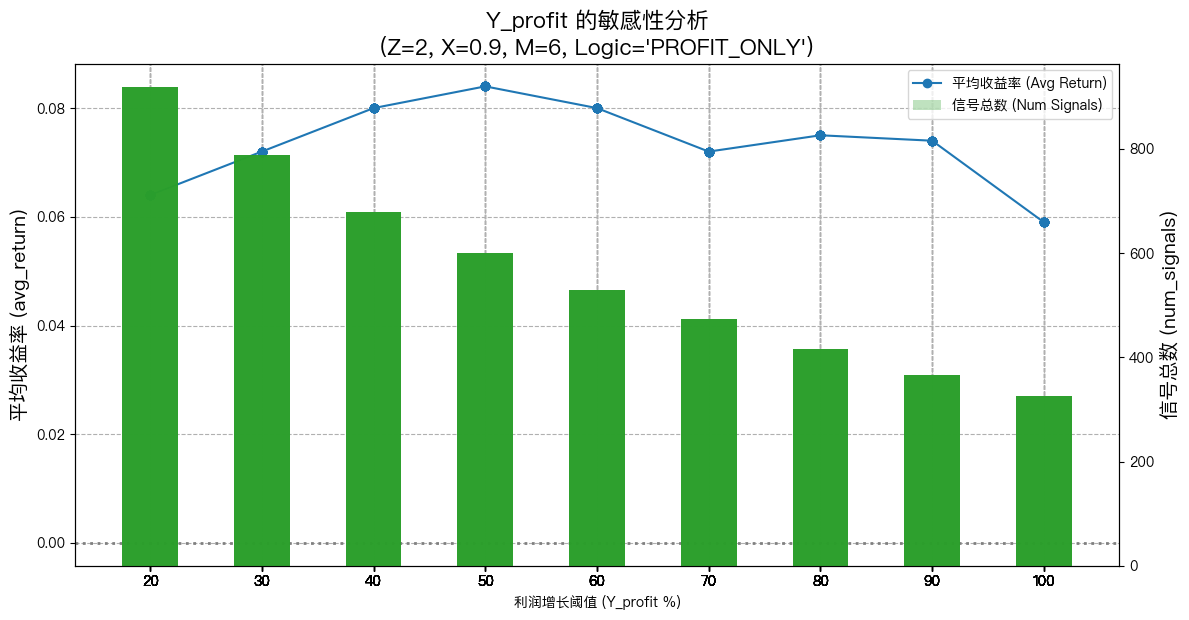

In [121]:
# 控制变量法，分析各参数对策略表现的影响
# 固定 Z=2，X=0.9，M=6, Logic='PROFIT_ONLY', 分析 Y_profit对 avg_return 的影响


# 1. 存储筛选后的 DataFrame
filtered_df = results_df[
    (results_df['Z'] == 2) & 
    (results_df['X'] == 0.9) & 
    (results_df['M'] == 6) & 
    (results_df['Logic'] == 'PROFIT_ONLY')
]

# 2. 按 Y_profit 排序，查看数据趋势
print("--- Y_profit 对策略表现的影响 (表格) ---")

analysis_table = filtered_df.sort_values(by='Y_profit')
display(analysis_table[['Y_profit', 'avg_return', 'num_signals', 'win_rate']])


print("\n--- Y_profit 对策略表现的影响 (图表) ---")
if analysis_table.empty:
    print("没有找到符合条件的数据。")
else:
    # --- 创建一个带双Y轴的图表 ---
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # 1. 绘制 avg_return (左 Y 轴)
    color = 'tab:blue'
    ax1.set_xlabel("利润增长阈值 (Y_profit %)")
    ax1.set_xticks(analysis_table['Y_profit'])
    ax1.set_ylabel("平均收益率 (avg_return)", color='black', fontsize=14)
    ax1.plot(analysis_table['Y_profit'], analysis_table['avg_return'], color=color, marker='o', label='平均收益率 (Avg Return)')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, linestyle='--') # 添加网格线
    ax1.axhline(0, color='grey', linestyle=':', linewidth=2) # 添加 0 收益线

    # 2. 创建第二个 Y 轴 (共享 X 轴)
    ax2 = ax1.twinx()  
    color = 'tab:green'
    ax2.set_ylabel("信号总数 (num_signals)", color='black', fontsize=14)
    #  绘制 num_signals，并使用条形图 (bar chart)
    ax2.bar(analysis_table['Y_profit'], analysis_table['num_signals'], color=color, alpha=0.3, width=5, label='信号总数 (Num Signals)')
    ax2.tick_params(axis='y', labelcolor='black')

    # 添加图例 (合并两个轴的图例)
    lines, labels = ax1.get_legend_handles_labels()
    bars, bar_labels = ax2.get_legend_handles_labels()
    ax2.legend(lines + bars, labels + bar_labels, loc="upper right")
    
    plt.title("Y_profit 的敏感性分析\n(Z=2, X=0.9, M=6, Logic='PROFIT_ONLY')", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

--- Y_sales 对策略表现的影响 (表格) ---


,Y_sales,avg_return,num_signals,win_rate
14327,5.0,0.044,1593,0.422
11951,5.0,0.044,1593,0.422
9575,5.0,0.044,1593,0.422
71,5.0,0.044,1593,0.422
16703,5.0,0.044,1593,0.422
...,...,...,...,...
2231,100.0,-0.127,128,0.242
6983,100.0,-0.127,128,0.242
21239,100.0,-0.127,128,0.242
11735,100.0,-0.127,128,0.242



--- Y_sales 对策略表现的影响 (图表) ---


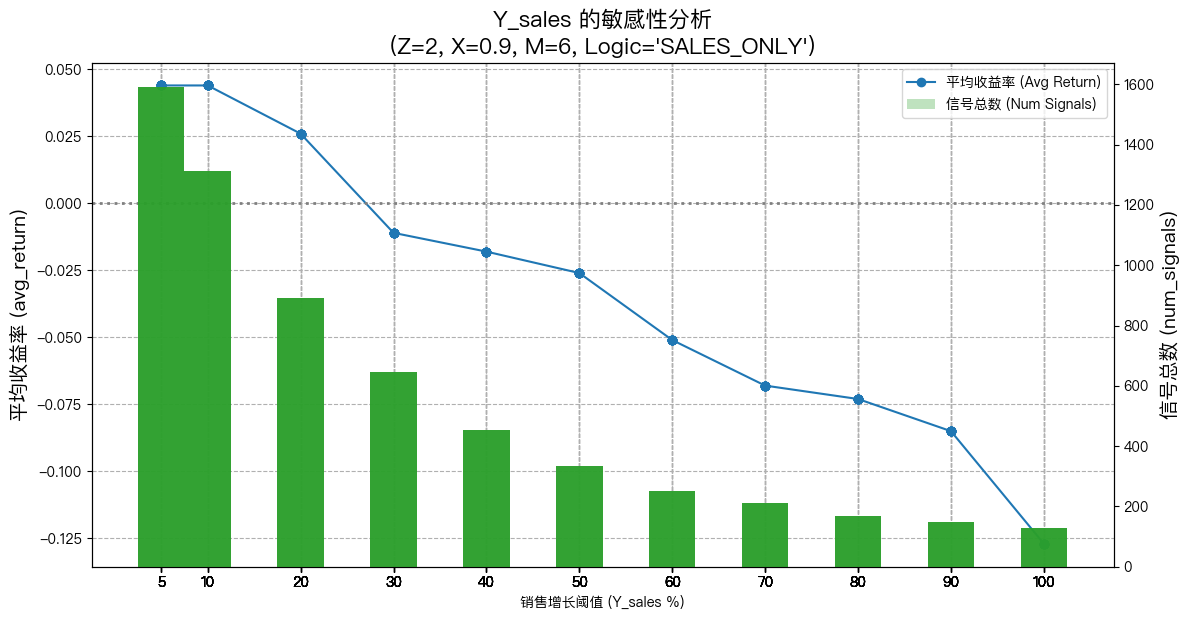

In [118]:
# 控制变量法，分析各参数对策略表现的影响
# 固定 Z=2，X=0.9，M=6, Logic='PROFIT_ONLY', 分析 Y_profit对 avg_return 的影响


# 1. 存储筛选后的 DataFrame
filtered_df = results_df[
    (results_df['Z'] == 2) & 
    (results_df['X'] == 0.9) & 
    (results_df['M'] == 6) & 
    (results_df['Logic'] == 'SALES_ONLY')
]

# 2. 按 Y_sales 排序，查看数据趋势
print("--- Y_sales 对策略表现的影响 (表格) ---")

analysis_table = filtered_df.sort_values(by='Y_sales')
display(analysis_table[['Y_sales', 'avg_return', 'num_signals', 'win_rate']])

print("\n--- Y_sales 对策略表现的影响 (图表) ---")
if analysis_table.empty:
    print("没有找到符合条件的数据。")
else:
    # --- 创建一个带双Y轴的图表 ---
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # 1. 绘制 avg_return (左 Y 轴)
    color = 'tab:blue'
    ax1.set_xlabel("销售增长阈值 (Y_sales %)")
    ax1.set_xticks(analysis_table['Y_sales'])
    ax1.set_ylabel("平均收益率 (avg_return)", color='black', fontsize=14)
    ax1.plot(analysis_table['Y_sales'], analysis_table['avg_return'], color=color, marker='o', label='平均收益率 (Avg Return)')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, linestyle='--') # 添加网格线
    ax1.axhline(0, color='grey', linestyle=':', linewidth=2) # 添加 0 收益线

    # 2. 创建第二个 Y 轴 (共享 X 轴)
    ax2 = ax1.twinx()  
    color = 'tab:green'
    ax2.set_ylabel("信号总数 (num_signals)", color='black', fontsize=14)
    #  绘制 num_signals，并使用条形图 (bar chart)
    ax2.bar(analysis_table['Y_sales'], analysis_table['num_signals'], color=color, alpha=0.3, width=5, label='信号总数 (Num Signals)')
    ax2.tick_params(axis='y', labelcolor='black')

    # 添加图例 (合并两个轴的图例)
    lines, labels = ax1.get_legend_handles_labels()
    bars, bar_labels = ax2.get_legend_handles_labels()
    ax2.legend(lines + bars, labels + bar_labels, loc="upper right")
    
    plt.title("Y_sales 的敏感性分析\n(Z=2, X=0.9, M=6, Logic='SALES_ONLY')", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

In [122]:
results_df

,Y_profit,Y_sales,Z,X,M,Logic,avg_return,median_return,win_rate,std_dev,sharpe_ratio,num_signals
8924,50.0,80.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
8492,50.0,60.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
7412,50.0,10.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
7628,50.0,20.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
7196,50.0,5.0,2,0.9,6,PROFIT_ONLY,0.084,-0.048,0.437,0.562,0.212,600
...,...,...,...,...,...,...,...,...,...,...,...,...
20894,100.0,80.0,4,0.5,6,AND,-0.240,-0.253,0.167,0.229,-1.482,30
18746,90.0,90.0,4,0.6,6,AND,-0.240,-0.253,0.167,0.229,-1.482,30
21122,100.0,90.0,4,0.6,6,AND,-0.240,-0.253,0.167,0.229,-1.482,30
18518,90.0,80.0,4,0.5,6,AND,-0.240,-0.253,0.167,0.229,-1.482,30


--- 分析 Z (连续季度) vs Y (利润增幅) ---
分析范围: Logic == 'PROFIT_ONLY'

--- 平均贡献 (在所有 Y 中) ---
Z
2    0.073333
3    0.015000
4   -0.044333
Name: avg_return, dtype: float64

--- 平均贡献 (在所有 Z 中) ---
Y_profit
40.0     0.038667
50.0     0.038333
30.0     0.033667
60.0     0.029333
20.0     0.028333
80.0     0.008000
70.0     0.007333
90.0    -0.020000
100.0   -0.031667
Name: avg_return, dtype: float64

--- 贡献值热力图 (平均收益率 avg_return) ---


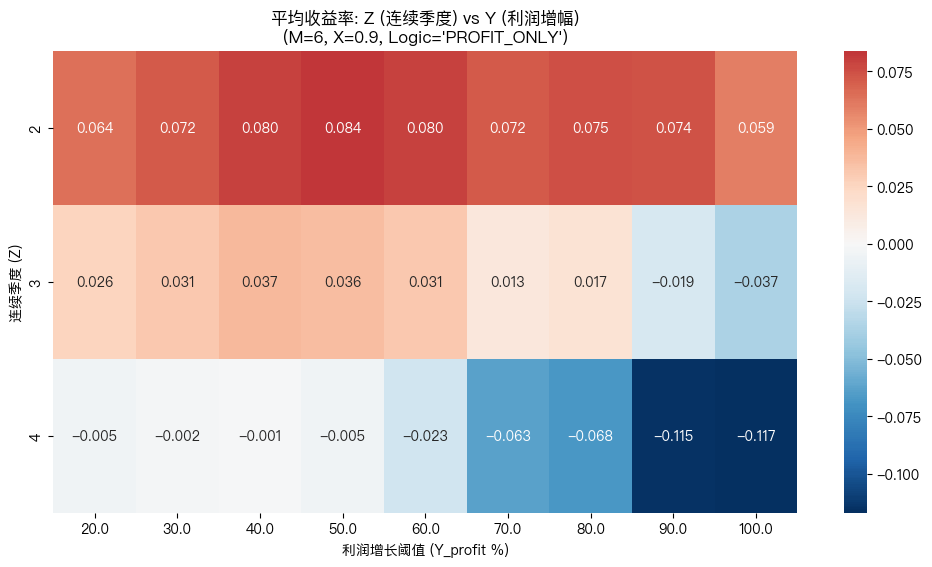

In [127]:
print("--- 分析 Z (连续季度) vs Y (利润增幅) ---")
print("分析范围: Logic == 'PROFIT_ONLY'")

# --- 1. 筛选出我们关心的数据 ---
# (我们假设 M 和 X 是固定的，你可以根据需要修改)
M_fixed = 6  # 假设我们只看 6 个月持有期
X_fixed = 0.9 # 假设我们只看 50% 行业阈值

df_analysis = results_df[
    (results_df['Logic'] == 'PROFIT_ONLY') &
    (results_df['M'] == M_fixed) &
    (results_df['X'] == X_fixed)
].dropna(subset=['avg_return'])

if df_analysis.empty:
    print(f"\n!! 警告: 找不到 (Logic='PROFIT_ONLY', M={M_fixed}, X={X_fixed}) 的数据")
    print("!! 请检查你的 param_grid 和 results_df。")

else:
    # --- 2. 简单聚合分析 (看平均贡献) ---
    print("\n--- 平均贡献 (在所有 Y 中) ---")
    print(df_analysis.groupby('Z')['avg_return'].mean().sort_values(ascending=False))
    
    print("\n--- 平均贡献 (在所有 Z 中) ---")
    print(df_analysis.groupby('Y_profit')['avg_return'].mean().sort_values(ascending=False))

    # --- 3. 核心分析：热力图 ---
    print("\n--- 贡献值热力图 (平均收益率 avg_return) ---")
    
    try:
        # 创建数据透视表
        pivot_avg_return = df_analysis.pivot_table(
            index='Z',          
            columns='Y_profit', 
            values='avg_return'
        )

        # 绘制热力图
        plt.figure(figsize=(12, 6))
        sns.heatmap(
            pivot_avg_return, 
            annot=True,     
            fmt=".3f",      
            
            # --- 【修改】 ---
            cmap="RdBu_r",  # 红色 (正) - 白色 (0) - 蓝色 (负)
            center=0        # 将颜色中心固定在 0
            # --- 结束修改 ---
        )
        plt.title(f"平均收益率: Z (连续季度) vs Y (利润增幅)\n(M={M_fixed}, X={X_fixed}, Logic='PROFIT_ONLY')")
        plt.xlabel("利润增长阈值 (Y_profit %)")
        plt.ylabel("连续季度 (Z)")
        plt.show()

    except Exception as e:
        print(f"无法绘制热力图: {e}")
        print("这通常发生在你的 'Z' 或 'Y_profit' 只有一个值时。")

--- 分析 Z (连续季度) vs Y (利润增幅) ---
分析范围: Logic == 'PROFIT_ONLY'

--- 平均贡献 (在所有 Y 中) ---
Z
2   -0.031364
3   -0.069636
4   -0.103000
Name: avg_return, dtype: float64

--- 平均贡献 (在所有 Z 中) ---
Y_profit
20.0    -0.068
30.0    -0.068
40.0    -0.068
50.0    -0.068
60.0    -0.068
70.0    -0.068
80.0    -0.068
90.0    -0.068
100.0   -0.068
Name: avg_return, dtype: float64

--- 贡献值热力图 (平均收益率 avg_return) ---


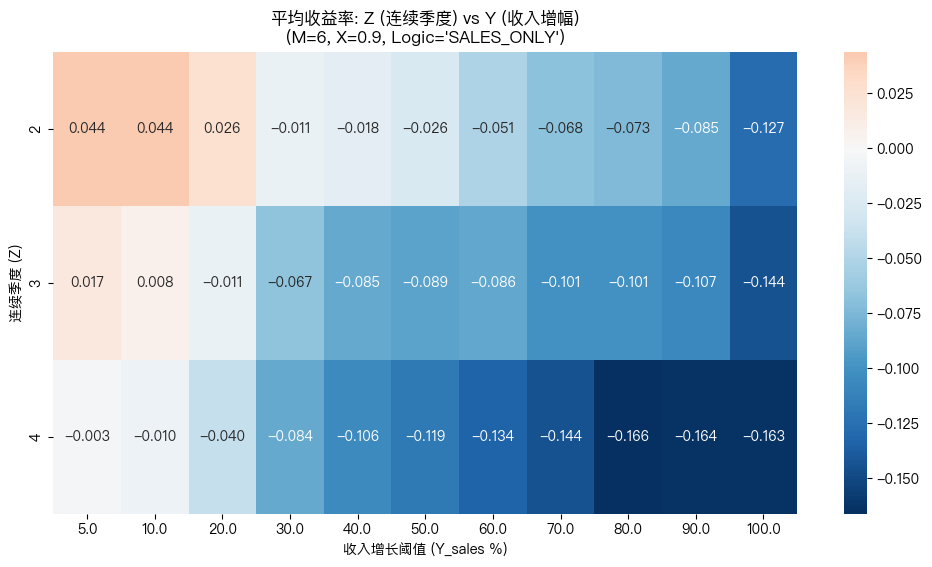

In [129]:
print("--- 分析 Z (连续季度) vs Y (利润增幅) ---")
print("分析范围: Logic == 'PROFIT_ONLY'")

# --- 1. 筛选出我们关心的数据 ---
# (我们假设 M 和 X 是固定的，你可以根据需要修改)
M_fixed = 6  # 假设我们只看 6 个月持有期
X_fixed = 0.9 # 假设我们只看 50% 行业阈值

df_analysis = results_df[
    (results_df['Logic'] == 'SALES_ONLY') &
    (results_df['M'] == M_fixed) &
    (results_df['X'] == X_fixed)
].dropna(subset=['avg_return'])

if df_analysis.empty:
    print(f"\n!! 警告: 找不到 (Logic='PROFIT_ONLY', M={M_fixed}, X={X_fixed}) 的数据")
    print("!! 请检查你的 param_grid 和 results_df。")

else:
    # --- 2. 简单聚合分析 (看平均贡献) ---
    print("\n--- 平均贡献 (在所有 Y 中) ---")
    print(df_analysis.groupby('Z')['avg_return'].mean().sort_values(ascending=False))
    
    print("\n--- 平均贡献 (在所有 Z 中) ---")
    print(df_analysis.groupby('Y_profit')['avg_return'].mean().sort_values(ascending=False))

    # --- 3. 核心分析：热力图 ---
    print("\n--- 贡献值热力图 (平均收益率 avg_return) ---")
    
    try:
        # 创建数据透视表
        pivot_avg_return = df_analysis.pivot_table(
            index='Z',          
            columns='Y_sales', 
            values='avg_return'
        )

        # 绘制热力图
        plt.figure(figsize=(12, 6))
        sns.heatmap(
            pivot_avg_return, 
            annot=True,     
            fmt=".3f",      
            
            # --- 【修改】 ---
            cmap="RdBu_r",  # 红色 (正) - 白色 (0) - 蓝色 (负)
            center=0        # 将颜色中心固定在 0
            # --- 结束修改 ---
        )
        plt.title(f"平均收益率: Z (连续季度) vs Y (收入增幅)\n(M={M_fixed}, X={X_fixed}, Logic='SALES_ONLY')")
        plt.xlabel("收入增长阈值 (Y_sales %)")
        plt.ylabel("连续季度 (Z)")
        plt.show()

    except Exception as e:
        print(f"无法绘制热力图: {e}")
        print("这通常发生在你的 'Z' 或 'Y_profit' 只有一个值时。")

In [130]:
results_df.to_csv('results/strategy_results.csv', index=False)

--- 正在从 results/strategy_results.csv 加载数据 ---
--- 策略参数敏感性分析 (基于平均收益率 avg_return) ---

--- Z 的平均影响 (表格) ---
       mean       std  count
Z                           
2  0.016002  0.040838   7128
3 -0.008355  0.041984   7128
4 -0.040404  0.051975   7128

--- X 的平均影响 (表格) ---
         mean       std  count
X                             
0.4 -0.005764  0.050056   3564
0.5 -0.010836  0.050399   3564
0.6 -0.010842  0.050771   3564
0.7 -0.012504  0.051126   3564
0.8 -0.012718  0.050994   3564
0.9 -0.012850  0.050930   3564

--- Logic 的平均影响 (表格) ---
                 mean       std  count
Logic                                 
AND         -0.041139  0.057388   5346
OR           0.012402  0.028308   5346
PROFIT_ONLY  0.015885  0.038268   5346
SALES_ONLY  -0.030823  0.046684   5346

--- Y_profit 的平均影响 (表格) ---
              mean       std  count
Y_profit                           
20.0     -0.006366  0.041955   2376
30.0     -0.005007  0.043390   2376
40.0     -0.004112  0.044953   2376
50.0     

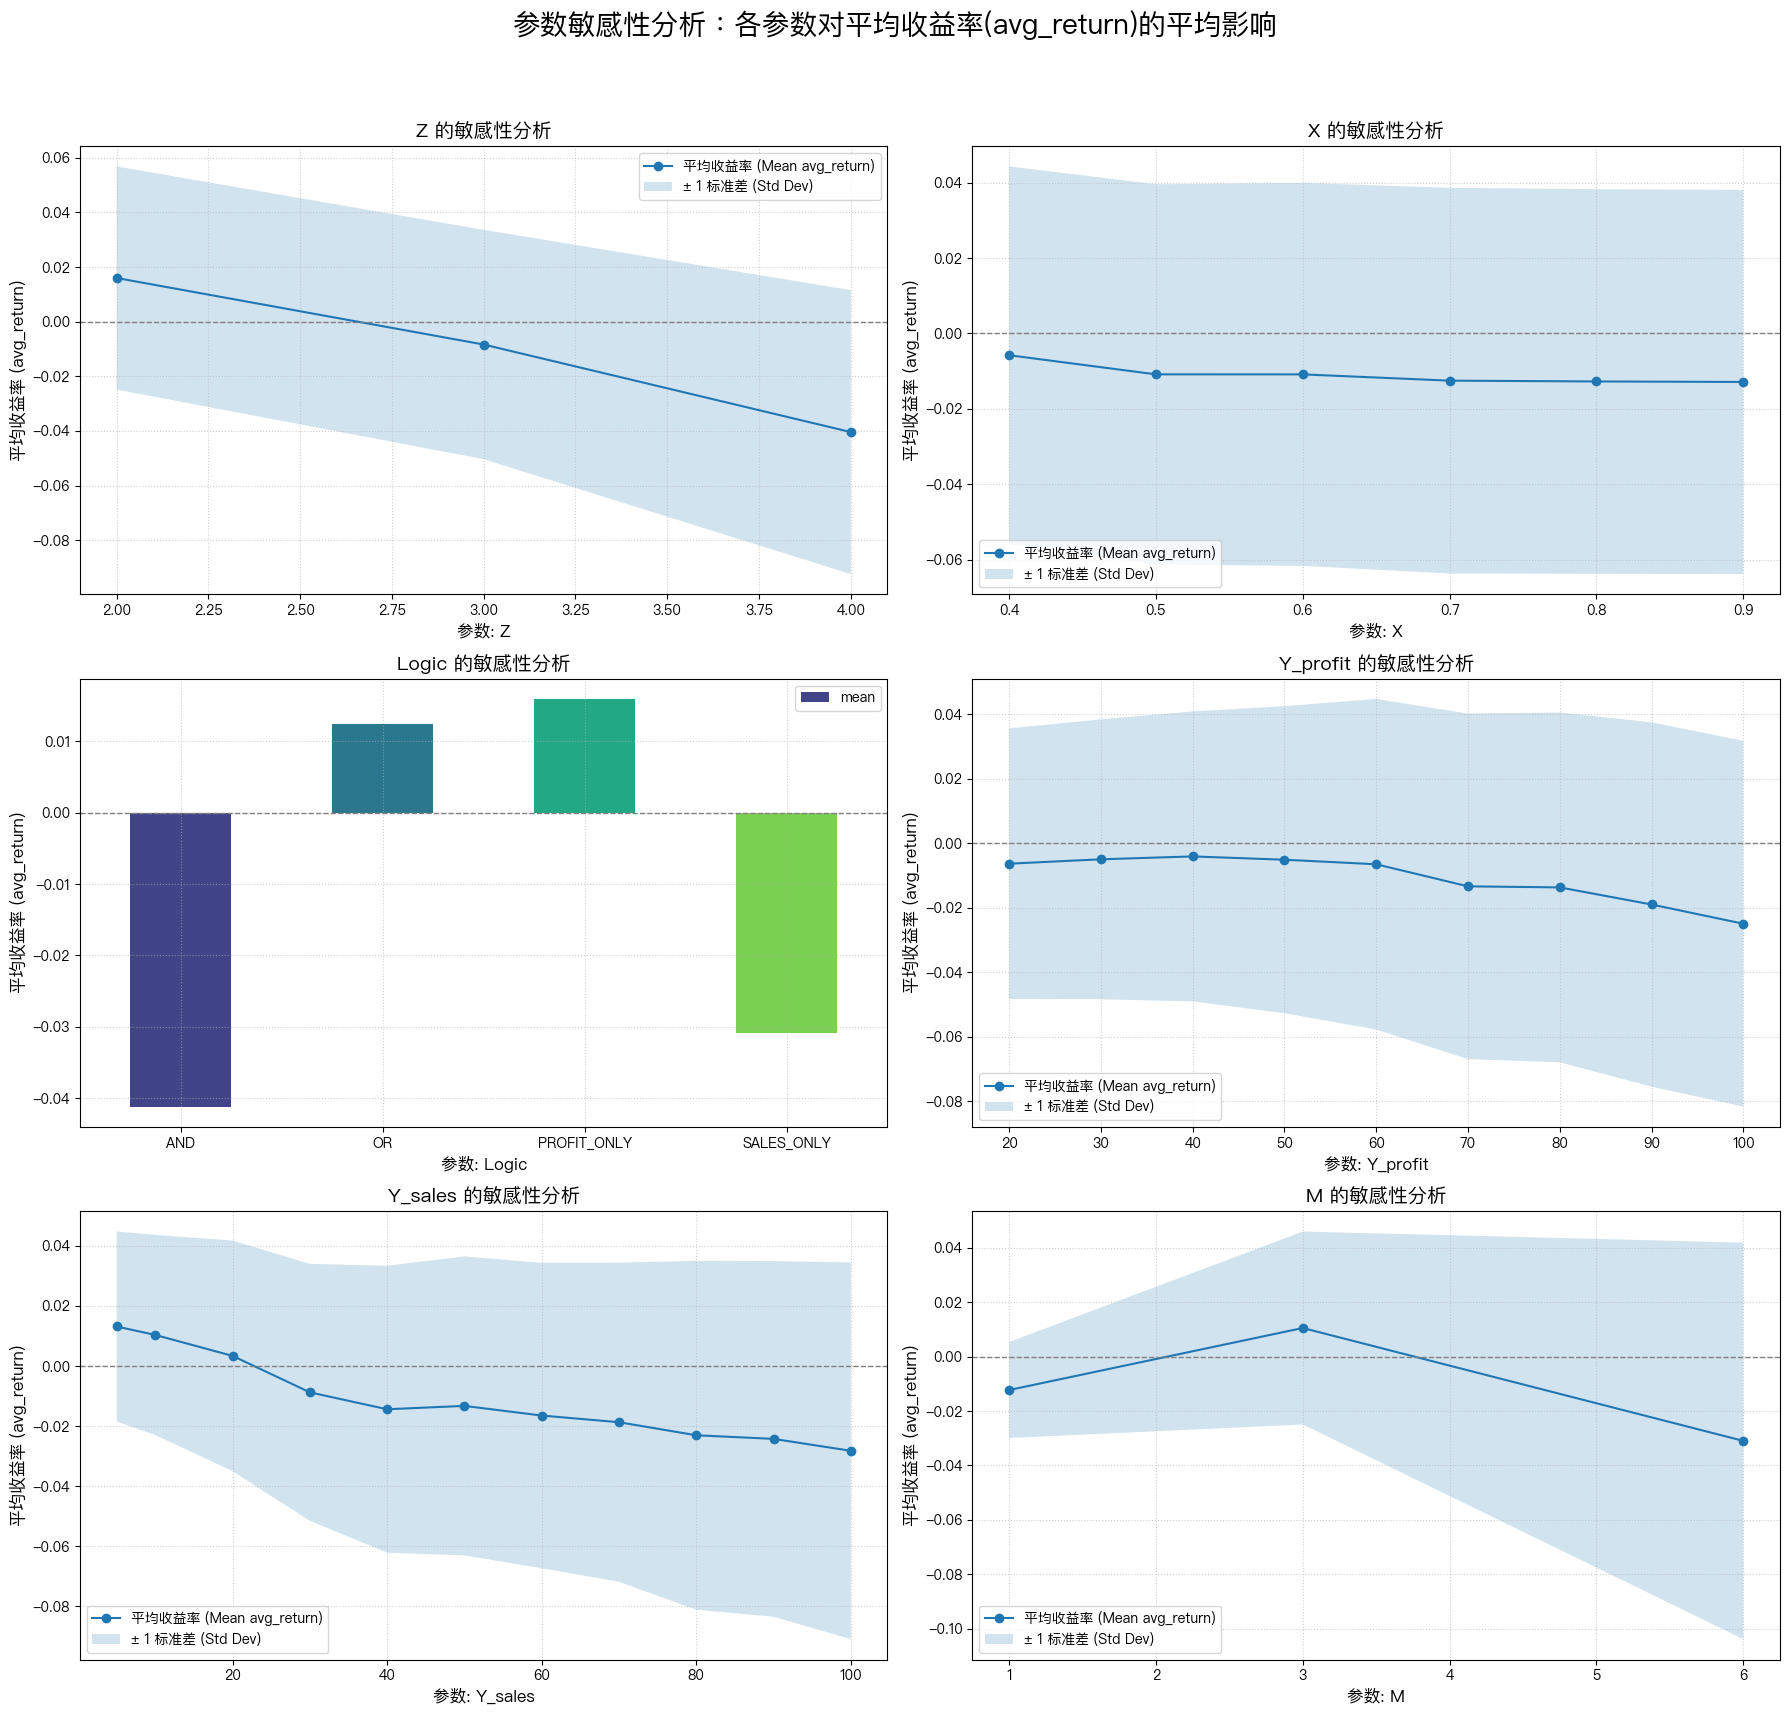

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. 加载数据 ---
# (我们假设 Excel 文件保存在 'results' 文件夹中)
results_file = "results/strategy_results.csv"

if not os.path.exists(results_file):
    print(f"错误：找不到文件 {results_file}")
    print("请先运行您的主参数扫描单元格，以生成此文件。")
else:
    print(f"--- 正在从 {results_file} 加载数据 ---")
    results_df = pd.read_csv(results_file)
    
    # 确保我们只使用有有效 avg_return 的数据
    df_analysis = results_df.dropna(subset=['avg_return']).copy()
    
    if df_analysis.empty:
        print("分析失败：加载的数据中没有有效的 avg_return 数据。")
    else:
        print("--- 策略参数敏感性分析 (基于平均收益率 avg_return) ---")
        
        # 定义要分析的参数列表
        params_to_analyze = ['Z', 'X', 'Logic', 'Y_profit', 'Y_sales', 'M']
        
        # 创建一个 3x2 的图表布局
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
        fig.suptitle('参数敏感性分析：各参数对平均收益率(avg_return)的平均影响', fontsize=20)
        
        # 将 axes 展平以便迭代
        axes = axes.flatten()
        
        for i, param in enumerate(params_to_analyze):
            if param in df_analysis.columns:
                # 1. 计算每个参数值的平均 avg_return
                param_effect = df_analysis.groupby(param)['avg_return'].agg(['mean', 'std', 'count'])
                param_effect = param_effect.sort_index()
                
                print(f"\n--- {param} 的平均影响 (表格) ---")
                print(param_effect)
                
                # 2. 绘图
                ax = axes[i]
                
                if pd.api.types.is_numeric_dtype(param_effect.index):
                    # 如果参数是数值型 (Y, Z, X, M)，画线图
                    ax.plot(param_effect.index, param_effect['mean'], marker='o', label='平均收益率 (Mean avg_return)')
                    
                    # 绘制置信区间 (mean +/- 1 std)
                    ax.fill_between(param_effect.index, 
                                    param_effect['mean'] - param_effect['std'], 
                                    param_effect['mean'] + param_effect['std'], 
                                    alpha=0.2, label='± 1 标准差 (Std Dev)')
                    ax.set_xlabel(f"参数: {param}", fontsize=12)
                
                else:
                    # 如果参数是类别型 (Logic)，画条形图
                    param_effect['mean'].plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(param_effect)))
                    ax.set_xlabel(f"参数: {param}", fontsize=12)
                    plt.setp(ax.get_xticklabels(), rotation=0)

                ax.set_ylabel("平均收益率 (avg_return)", fontsize=12)
                ax.axhline(0, color='grey', linestyle='--', linewidth=1)
                ax.legend()
                ax.set_title(f"{param} 的敏感性分析", fontsize=14)
                ax.grid(True, linestyle=':', alpha=0.6)

        # 隐藏任何未使用的子图
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()